In [1]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats
from socket import gethostname

sns.set(style="white")
sns.set_context("notebook")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

tick_setup = {'labelsize' : SMALL_SIZE,
              'major.pad': 0}

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', **tick_setup)    # fontsize of the tick labels
plt.rc('ytick', **tick_setup)
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

hostname = gethostname().split('.')[0]
if hostname == 'Pluripa':
    home_dir = "/Users/weinberz/"
    box_dir = "/Users/weinberz/Box Sync/"
else:
    home_dir = "/Volumes/Coatamer/Users/weinberz/"
    box_dir = "/Volumes/Coatamer/Users/weinberz/Box/"

def gate_density (df, threshold, y_var='FSC-A', x_var='SSC-A'):
    
    ymin = df[y_var].min()
    ymax = df[y_var].max()
    xmin = df[x_var].min()
    xmax = df[x_var].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini[x_var], df_mini[y_var]])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df[x_var], df[y_var]])
    df2 = df[df.gate > cut]
    return df2

In [2]:
outputdir = home_dir + "Google Drive/HES Lab/SARSNotch/SARSNotch Manuscript/jupyter_out/"

In [3]:
folder= box_dir + "BadIdea/Flow/20210212 - PTV ZYW057/"

In [8]:
ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

df=pd.DataFrame()
aa=1
    #load all fcs files
for fdn in ffolderlist:
    ffilelist = os.listdir(folder+fdn)
    for fn in ffilelist:
        filename, file_ext = os.path.splitext(fn)
        if file_ext ==".fcs":
            path = folder + fdn + "//" + fn
            meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
            df1["WellName"]=fn.split("_")[3].split(".")[0]
            df1["WellNumber"]= aa
            df=df.append(df1)
            aa=aa+1

# metadata file
meta = folder+ "metadata.csv"
df1=pd.read_csv(meta, names=["WellName", "CellLine","Condition", 'Replicate'])

df=df1.merge(df, on=["WellName"])

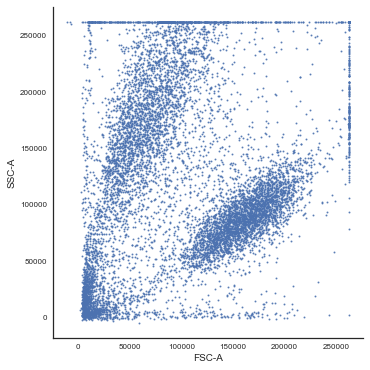

In [9]:
sns.lmplot(y="SSC-A", x="FSC-A", data=df[df["WellName"].isin(['A02'])], fit_reg=False, scatter_kws={'s': 1})
plt.show()

In [10]:
#remove small events
df2 =df[df["FSC-A"]>5E4]
df2 =df2[df2["SSC-A"]>2.5E4]

#remove NAs
df2= df2.loc[(df2.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

#gate cells
df2 = gate_density(df2, 0.1)

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

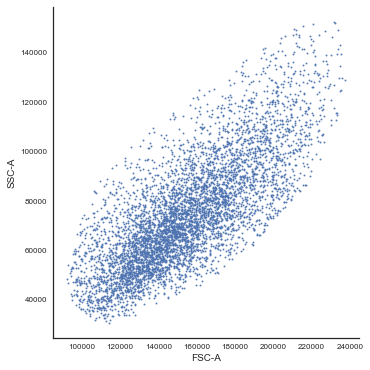

In [18]:
#Visualize populations for Jurkats (well B01) and K562s (well A02)
sns.lmplot(y="SSC-A", x="FSC-A", data=df2[df2["WellName"].isin(['A02'])], fit_reg=False, scatter_kws={'s': 1})
plt.show()

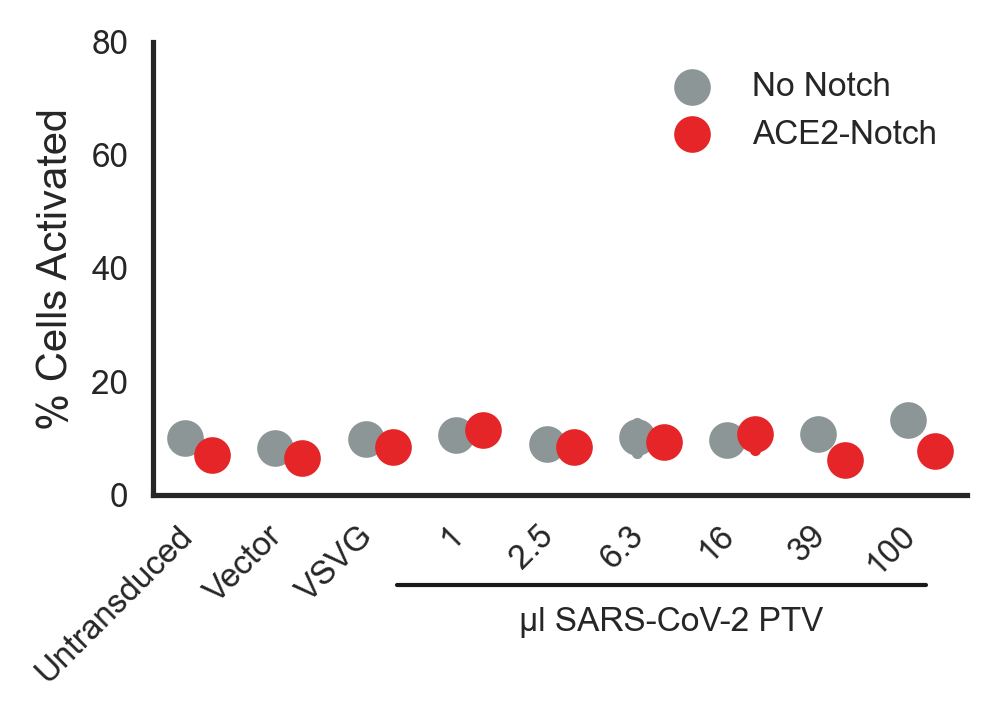

In [12]:
baseline = df2[(df2.CellLine == 'No Notch') &
               (df2.Condition == 'Untransduced')]['logBV 421-A']
qt = np.percentile(baseline, 90)
activated = (df2
 .groupby(['CellLine','Condition','Replicate'])['logBV 421-A']
 .apply(lambda x: 100*np.sum(x>qt)/len(x))
 .reset_index())

with sns.color_palette(['#8C9696','#E52527']):
    plt.figure(figsize=(3.5,2), dpi=300)
    g = sns.pointplot(data=activated, x='Condition', y='logBV 421-A', hue='CellLine',
                      order=['Untransduced', 'Vector', 'VSVG', '1','2.5', '6.3', '16','39','100'],
                      hue_order=['No Notch', 'ACE2-Notch'],
                      join=False,
                      dodge=0.3)
    plt.xticks(rotation=45, ha='right')
    line = mpl.lines.Line2D([0.3, 0.95],[-.2, -.2], 
                            lw=1, color='k', clip_on=False, 
                            transform=g.axes.transAxes)
    g.axes.add_line(line)
    g.axes.text(0.45, -.3, 'µl SARS-CoV-2 PTV', 
                clip_on=False, transform=g.axes.transAxes)
    g.legend().remove()
    plt.legend(frameon=False)
    plt.ylim([0,80])
    plt.xlabel('')
    plt.ylabel('% Cells Activated')
    sns.despine()
    plt.savefig(outputdir + "ace2_activation_ptv_72.svg", bbox_inches='tight')